In [93]:
# from google.colab import drive
# drive.mount('/content/drive')

In [94]:
# import os
# os.chdir('/content/drive/MyDrive/GSS16')

In [95]:
import pandas as pd
import numpy as np
import pyreadr

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, gamma, poisson

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.gam.api import GLMGam, BSplines

from statsmodels.tools.eval_measures import rmse, mse

from zmq.constants import NULL

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [96]:
# gss16 = pd.read_csv('gss16.csv')
# gss16

In [97]:
df = pyreadr.read_r('./data/gss16.rda')
gss16 = df['gss16']

# 1. Tiền xử lý dữ liệu và thống kê mô tả

Loại bỏ các row có trường nhãn (thời gian dùng email bị null)

In [98]:
dat = gss16[(gss16['emailmin'].notna())&(gss16['emailhr'].notna())]

Tạo cột tổng thời gian dùng email từ 2 cột về số giờ, số phút dùng email. Sau đó xóa 2 cột giờ/phút dùng email ban đầu

In [99]:
dat["emailmintotal"] = dat["emailmin"] + dat["emailhr"]*60
dat.drop(["emailhr", "emailmin"], axis=1, inplace= True)

Scale trường emailmintotal, educ về khoảng [0, 1]

In [100]:
min_time=dat["emailmintotal"].min()
max_time=dat["emailmintotal"].max()
dat["emailmintotal_center"] = [(x-min_time)/(max_time-min_time)+0.001 for x in dat["emailmintotal"]]

# dat["emailmintotal_center"] = dat["emailmintotal"] + 1

min_educ=dat["educ"].min()
max_educ=dat["educ"].max()
dat["educ_center"] = [(x-min_educ)/(max_educ-min_educ) for x in dat["educ"]]

# dat["educ_center"] = dat['educ']

dat.drop(["emailmintotal", "educ"], axis=1, inplace= True)

In [101]:
# dat.shape

In [102]:
# dat.describe()

Như vậy, dữ liệu giờ chỉ còn 2 cột dữ liệu dạng số. Các cột còn lại là loại categorical. Ta kiểm tra số giá trị null tại mỗi cột và thống kê số lượng các giá trị khác null.

In [103]:
# for col in dat.columns:
#     if col in ["harass5", "polviews", "advfront", "snapchat", "instagrm", "wrkstat"]:
#         print("field: ", col)
#         print('- number of NaN value: {0:2d} ({1:.2f}%)'.format(dat[col].isna().sum(), dat[col].isna().sum()/1649))
#         print('- values:')
#         print(dat[col].value_counts())
#         print('\n')
#     elif col == "educ_center":
#         print("field: ", col)
#         print('- number of NaN value:', dat[col].isna().sum())
#         print('\n')

Như vậy, 1 số cột categorical có tỷ lệ null khá nhiều (harass5 có 3/4 giá trị null, advfront có 1/4 số dòng null, snapchat và instagrm có gần 60% số dòng null). Vì vậy, với các cột categorical, ta mã hóa các giá trị null thành 1 nhóm riêng.

Cột dữ liệu số có 1 mẫu educ bị null. Vì số lượng nhỏ nên ta loại bỏ mẫu này.

In [104]:
dat = dat[dat['educ_center'].notna()]

dat.fillna("Not give", inplace=True)

In [105]:
dat.replace("Does not apply (i do not have a job/superior/co-worker)", "Does not apply", inplace=True)

**1.a. Kiểm tra phân phối của biến phụ thuôc**

In [106]:
# plt.figure(figsize=(20, 5))
# plt.boxplot(dat['emailmintotal_center'], vert=False)
# plt.show()

Có thể thấy dữ liệu emailmintotal rất phân tán, giá trị trong khoảng [0, 6000]. Dữ liệu tập trung nhiều ở vùng giá trị thấp, hình ảnh right skewed rõ nét.

Ta xem thêm biểu đồ histogram về phân phối của dữ liệu:

In [107]:
# dat['emailmintotal_center'].hist(bins = 1300)
# plt.ylim([0,100])

Có thể thấy, emailmintotal là biến liên tục không âm, gợi ý về phân phối Gamma (ta có thể cộng thêm 1 hằng số dương để đảm bảo giá trị luôn dương). Và với biểu đồ histogram phía trên cũng có hình ảnh phân phối Gamma.

Ta sẽ dùng biểu đồ QQplot để kiểm tra thêm việc này.

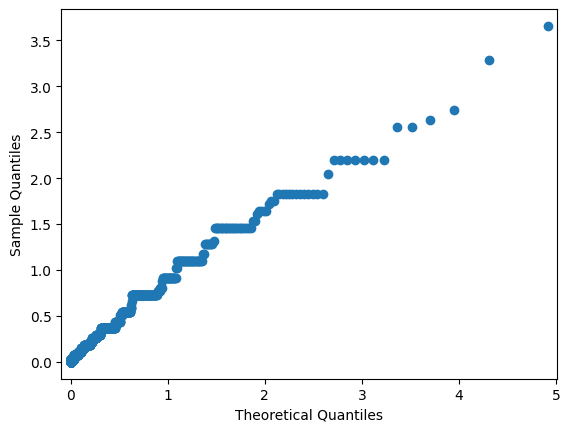

In [108]:
# qqplot(dat["emailmintotal_center"],gamma,fit=True)
qqplot(dat["emailmintotal_center"],gamma,fit=True)
plt.show()

Như vậy, emailmintotal khá khớp với phân phối **Gamma**

Để đảm bảo điều kiện của phân phối Gamma (emailmintotal dương), ta cộng vào nó 1 hằng số dương.

In [109]:
##### dat['emailmintotal_center'] += 1e-3

**1.b. Xem xét sự phụ thuộc của biến đầu ra so với các biến giải thích**

Xem xét emailmintotal đối với các cột categorical

In [110]:
# import seaborn as sns

# plt.figure(figsize=(20, 5))
# sns.boxplot(data=dat, x="emailmintotal_center", y="harass5")
# plt.xlim([0, 1])
# plt.show()

# plt.figure(figsize=(20, 5))
# sns.boxplot(data=dat, x="emailmintotal_center", y="polviews")
# plt.xlim([0, 1])
# plt.show()

# plt.figure(figsize=(20, 5))
# sns.boxplot(data=dat, x="emailmintotal_center", y="advfront")
# plt.xlim([0, 1])
# plt.show()

# plt.figure(figsize=(20, 5))
# sns.boxplot(data=dat, x="emailmintotal_center", y="snapchat")
# plt.xlim([0, 1])
# plt.show()

# plt.figure(figsize=(20, 5))
# sns.boxplot(data=dat, x="emailmintotal_center", y="instagrm")
# plt.xlim([0, 1])
# plt.show()

# plt.figure(figsize=(20, 5))
# sns.boxplot(data=dat, x="emailmintotal_center", y="wrkstat")
# plt.xlim([0, 1])
# plt.show()

Nhận xét:
- **harass**: nhóm không đi làm ít dùng email hơn 3 nhóm còn lại.
- **polviews**: nhóm Extrmly conservative dùng email ít hơn các nhóm còn lại.
- **advfront**: nhóm Strong disagree dùng nhiều email hơn hẳn các nhóm còn lại, sau đó tới nhóm Strong agree. Nhóm Dont know là dùng email ít nhất.
- **snapchat, instagrm**:  Nhân tố Snapchat và nhân tố Instagram có phân bố như nhau trên cả 3 giá trị (Dont know, No, Yes). Trong đó nhóm Yes dùng email nhiều hơn 2 nhóm còn lại, nghĩa là người dùng mạng xã hội có xu hướng dùng email nhiều hơn.
- **wrkstat**: nhóm "working fulltime" dùng email nhiều hơn hẳn các nhóm còn lại. Các nhóm không đi làm (Keeping house, Retired, Unempl/laid off, School, Other) có mức dùng email ít nhất. Các nhóm làm bán thời gian (working parttime, temp not working) có mức dùng email ở giữa nhóm đi làm và nhóm không đi làm.

Bản thân trong mỗi nhóm, số lượng outlier vẫn khá nhiều (dữ liệu khá phân tán).

Xem xét sự phụ thuộc của emailmintotal đối với biến educ (biến dạng số duy nhất ở đây)

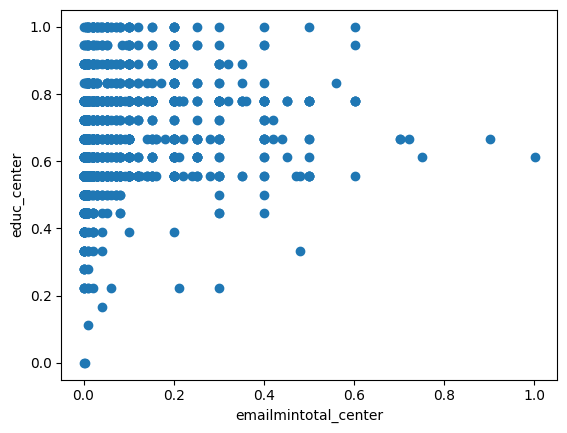

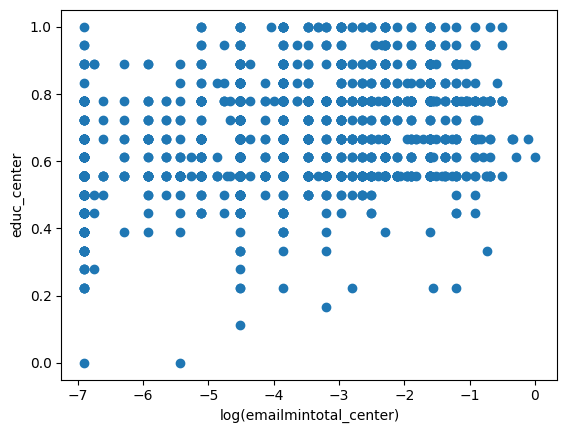

In [111]:
plt.scatter(dat["emailmintotal_center"], dat["educ_center"])
plt.xlabel("emailmintotal_center")
plt.ylabel("educ_center")
plt.show()

plt.scatter(np.log(dat["emailmintotal_center"]), dat["educ_center"])
plt.xlabel("log(emailmintotal_center)")
plt.ylabel("educ_center")
plt.show()


Biểu đồ scatter giữa educ và emailmintotal chưa thấy rõ được quan hệ tuyến tính giữa 2 biến này.

Ta chuyển scale cho emailmintotal bằng hàm log và kiểm tra lại. Ta thấy educ có quan hệ gần như tuyến tính với log(emailmintotal), mặc dù độ phân tán khá lớn. Điều này gợi ý ta dùng **link function là hàm log**.

Trong phần tiếp theo ta sẽ lựa chọn và xây dựng mô hình để dự đoán cho emailmintotal. **2 mô hình được lựa chọn thử nghiệm là GLM (Generalized Linear Model) và GAM (Generalized Additive Model).**

Trước tiên, ta tạm chia tập train/test theo tỷ lệ 80:20:

In [112]:
# dat_dm = pd.get_dummies(dat, dtype=int)
# dat_dm['emailmintotal_center'] += 1e-2

# y = dat_dm['emailmintotal_center']
# X = dat_dm.drop(columns=['emailmintotal_center'],axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



dat_train = dat.sample(frac = 0.8, random_state = 42)
dat_test = dat.drop(dat_train.index)

# 2. Mô hình GLM

**2.a. Lựa chọn thuộc tính**

Sau đó ta thử cho tất cả các cột vào fit mô hình GLM xem kết quả như thế nào:

In [113]:
formula_str = 'emailmintotal_center ~ harass5 + educ_center + polviews + advfront + snapchat + instagrm + wrkstat'

fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
fitted_glm.summary()


# fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.InverseGaussian(link=sm.families.links.Log())).fit()

### dummies
## fitted_glm = sm.GLM(y_train, X_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

# print('AIC: ', fitted_glm.aic)

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1318
Model:                              GLM   Df Residuals:                     1291
Model Family:                     Gamma   Df Model:                           26
Link Function:                      Log   Scale:                          2.5385
Method:                            IRLS   Log-Likelihood:                 2436.9
Date:                  Mon, 14 Aug 2023   Deviance:                       2690.9
Time:                          20:40:27   Pearson chi2:                 3.27e+03
No. Iterations:                     100   Pseudo R-squ. (CS):             0.1317
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.2444      1.259     -2.577      0.010      -5.712      -0.777
harass5[T.No]                        0.7432      0.432      1.721      0.085      -0.103       1.590
harass5[T.Not give]                 -1.7287      1.211     -1.427      0.153      -4.102       0.645
harass5[T.Yes]                       1.1378      0.484      2.350      0.019       0.189       2.087
polviews[T.Extremely liberal]       -0.4054      0.240     -1.690      0.091      -0.876       0.065
polviews[T.Extrmly conservative]    -0.6525      0.264     -2.469      0.014      -1.171      -0.134
polviews[T.Liberal]                 -0.1716      0.172     -0.999      0.318      -0.508       0.165
polviews[T.Moderate]                 0.0116      0.138      0.084      0.933      -0.259       0.282
polviews[T.Not give]                 0.5442      0.267      2.040      0.041       0.021       1.067
polviews[T.Slghtly conservative]    -0.2774      0.164     -1.689      0.091      -0.599       0.044
polviews[T.Slightly liberal]        -0.0568      0.178     -0.318      0.750      -0.406       0.293
advfront[T.Disagree]                 0.4395      0.166      2.652      0.008       0.115       0.764
advfront[T.Dont know]               -0.3761      0.518     -0.726      0.468      -1.391       0.639
advfront[T.Not give]                -2.5818      1.140     -2.264      0.024      -4.817      -0.347
advfront[T.Strongly agree]           0.0857      0.116      0.738      0.460      -0.142       0.313
advfront[T.Strongly disagree]        0.4448      0.569      0.782      0.434      -0.670       1.559
snapchat[T.Not give]                -0.0234      0.057     -0.409      0.682      -0.135       0.089
snapchat[T.Yes]                      0.2208      0.188      1.172      0.241      -0.148       0.590
instagrm[T.Not give]                -0.0234      0.057     -0.409      0.682      -0.135       0.089
instagrm[T.Yes]                      0.0425      0.169      0.252      0.801      -0.289       0.374
wrkstat[T.Other]                     1.2755      0.399      3.199      0.001       0.494       2.057
wrkstat[T.Retired]                   0.2672      0.185      1.441      0.150      -0.096       0.631
wrkstat[T.School]                    0.2052      0.310      0.663      0.507      -0.402       0.812
wrkstat[T.Temp not working]          0.7122      0.333      2.140      0.032       0.060       1.365
wrkstat[T.Unempl, laid off]          0.8971      0.264      3.397      0.001       0.379       1.415
wrkstat[T.Working fulltime]          1.2653      0.165      7.648      0.000       0.941       1.590
wrkstat[T.Working parttime]          0.7501      0.199      3.761      0.000       0.359       1.141
educ_center                    

Nhìn vào kết quả của mô hình sau khi fit, với mức ý nghĩa 5% thì thuộc tính snapchat và instagrm không ảnh hưởng đến mô hình.

Ta loại 2 thuộc tính này và fit lại mô hình thử xem

In [114]:
formula_str = 'emailmintotal_center ~ wrkstat + educ_center + polviews + advfront + harass5'

fitted_glm = NULL
# fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.InverseGaussian(link=sm.families.links.Log())).fit()

fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1318
Model:                              GLM   Df Residuals:                     1294
Model Family:                     Gamma   Df Model:                           23
Link Function:                      Log   Scale:                          2.4903
Method:                            IRLS   Log-Likelihood:                 2441.4
Date:                  Mon, 14 Aug 2023   Deviance:                       2699.9
Time:                          20:40:27   Pearson chi2:                 3.22e+03
No. Iterations:                      22   Pseudo R-squ. (CS):             0.1317
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.2474      1.236     -2.628      0.009      -5.670      -0.825
wrkstat[T.Other]                     1.2419      0.394      3.148      0.002       0.469       2.015
wrkstat[T.Retired]                   0.2334      0.182      1.281      0.200      -0.124       0.590
wrkstat[T.School]                    0.2277      0.304      0.749      0.454      -0.368       0.823
wrkstat[T.Temp not working]          0.7516      0.328      2.292      0.022       0.109       1.394
wrkstat[T.Unempl, laid off]          0.9265      0.261      3.554      0.000       0.416       1.437
wrkstat[T.Working fulltime]          1.2661      0.163      7.748      0.000       0.946       1.586
wrkstat[T.Working parttime]          0.7756      0.197      3.934      0.000       0.389       1.162
polviews[T.Extremely liberal]       -0.4381      0.237     -1.849      0.064      -0.903       0.026
polviews[T.Extrmly conservative]    -0.6573      0.262     -2.512      0.012      -1.170      -0.145
polviews[T.Liberal]                 -0.1687      0.170     -0.994      0.320      -0.501       0.164
polviews[T.Moderate]                 0.0240      0.136      0.176      0.860      -0.243       0.291
polviews[T.Not give]                 0.5562      0.264      2.107      0.035       0.039       1.074
polviews[T.Slghtly conservative]    -0.2743      0.163     -1.688      0.091      -0.593       0.044
polviews[T.Slightly liberal]        -0.0690      0.176     -0.391      0.696      -0.415       0.277
advfront[T.Disagree]                 0.4452      0.164      2.715      0.007       0.124       0.767
advfront[T.Dont know]               -0.4267      0.512     -0.833      0.405      -1.431       0.578
advfront[T.Not give]                -2.5886      1.125     -2.300      0.021      -4.794      -0.383
advfront[T.Strongly agree]           0.0843      0.115      0.734      0.463      -0.141       0.310
advfront[T.Strongly disagree]        0.4236      0.563      0.752      0.452      -0.680       1.527
harass5[T.No]                        0.7940      0.427      1.861      0.063      -0.042       1.630
harass5[T.Not give]                 -1.7383      1.197     -1.452      0.147      -4.085       0.609
harass5[T.Yes]                       1.1636      0.478      2.434      0.015       0.227       2.100
educ_center                          2.0454      0.308      6.633      0.000       1.441       2.650
====================================================================================================
"""

Nhận xét:

So với mô hình đầy đủ tất cả các feature ban đầu, mô hình phía trên có $R^2$ giảm không đáng kể nhưng mô hình đã đơn giản được 2 biến. Như vậy việc bỏ bớt feature không quan trọng của ta là đúng đắn.

Với mức ý nghĩa 5%, tất cả các feature giữ lại trong mô hình (wrkstat, educ, polviews, advfront, harass5) đều có ý nghĩa thống kê

**2.b. Diagnostic**

**Phần dư**

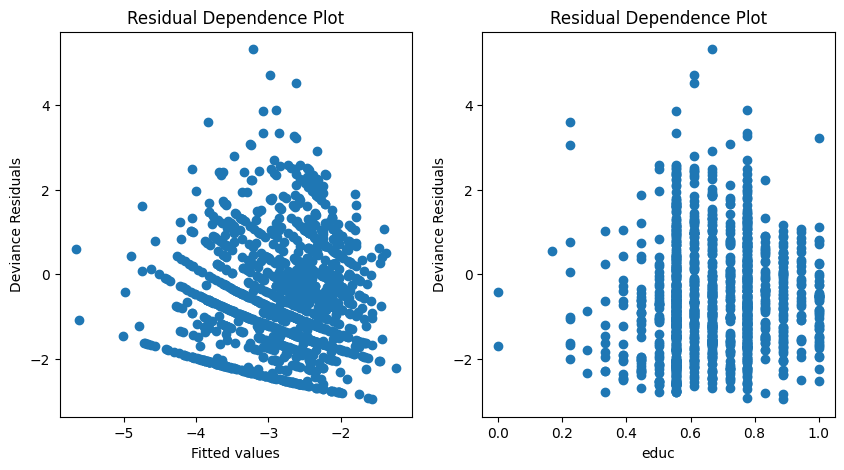

In [115]:
resid = fitted_glm.resid_deviance

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(np.log(fitted_glm.mu), resid)
# ax[0].hlines(0, 0, 1)
ax[0].set_title('Residual Dependence Plot')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_xlabel('Fitted values')

X_train = dat_train.drop(["emailmintotal_center"], axis=1)
ax[1].scatter(X_train['educ_center'], resid)
# ax[1].hlines(0, 0, 1)
ax[1].set_title('Residual Dependence Plot')
ax[1].set_ylabel('Deviance Residuals')
ax[1].set_xlabel('educ')
plt.show()

Nhận thấy, giá trị phần dư chuẩn hóa theo biến educ và fitted values có phân phối tương đối cân bằng xung quanh trục y=0.

Ta tiếp tục kiểm tra phân phối chuẩn của phần dư bằng biểu đồ QQplot

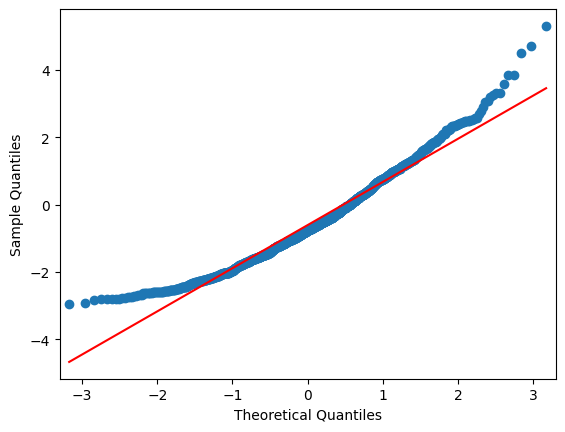

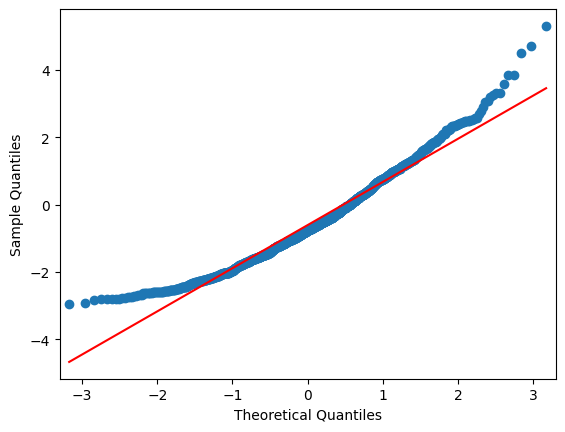

In [116]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

Biểu đồ qqplot cho thấy phần dư chuẩn hóa khá khớp với phân phối chuẩn.

Như vậy, mô hình là hợp lý với dữ liệu.


**Các điểm Infuence**

Các điểm influence là các điểm không tuân theo xu hướng chung của các điểm khác trong tập dữ liệu (outlier) và ảnh hưởng nghiêm trọng đến mô hình. Nó là các điểm có phần dư lớn và giá trị đòn bẩy (leverage) lớn.

Vì các điểm này không thể hiện xu hướng chung của dữ liệu, nó gây nhiễu cho mô hình. Mục tiêu của ta làm tìm các điểm này và loại nó khỏi dữ liệu train, sau đó fit lại để có mô hình tốt hơn.

Các điểm Influence được đánh giá qua giá trị Cook's distance.

In [117]:
infl = fitted_glm.get_influence()

summ_df = infl.summary_frame()

summ_df[["cooks_d", "standard_resid", "hat_diag", "dffits_internal"]].sort_values("cooks_d", ascending=False)[:10]

# cook_df = summ_df[["cooks_d", "standard_resid", "hat_diag", "dffits_internal"]].sort_values("cooks_d", ascending=False)
# cut_off = 4/len(dat_train)
# outlier = cook_df[cook_df["cooks_d"]>cut_off].index.values.tolist()
# len(outlier) # 109

,cooks_d,standard_resid,hat_diag,dffits_internal
2146,2.596624,12.690348,0.279002,7.551139
263,2.184631,10.566279,0.319551,6.826442
2362,2.174943,9.998486,0.343032,6.724674
1583,1.017832,7.490995,0.303291,4.580353
2354,0.620537,5.700288,0.314288,3.734017
620,0.416985,1.251835,0.864611,3.139379
377,0.341800,2.758610,0.518759,2.794730
2288,0.338738,6.090667,0.179758,2.784835
431,0.330675,6.751776,0.148277,2.906112
1491,0.202084,3.348083,0.302000,2.141122


Quan sát chi tiết các điểm có giá trị Cooks_d lớn nhất:

In [118]:
dat_train.loc[[1583, 2146, 263, 2362]]

,harass5,polviews,advfront,snapchat,instagrm,wrkstat,emailmintotal_center,educ_center
1583,No,Not give,Not give,No,No,Keeping house,0.601,0.777778
2146,Not give,Slghtly conservative,Disagree,Not give,Not give,Retired,0.721,0.666667
263,Not give,Liberal,Agree,Not give,Not give,"Unempl, laid off",0.751,0.611111
2362,Yes,Moderate,Not give,Not give,Not give,Working parttime,1.001,0.611111


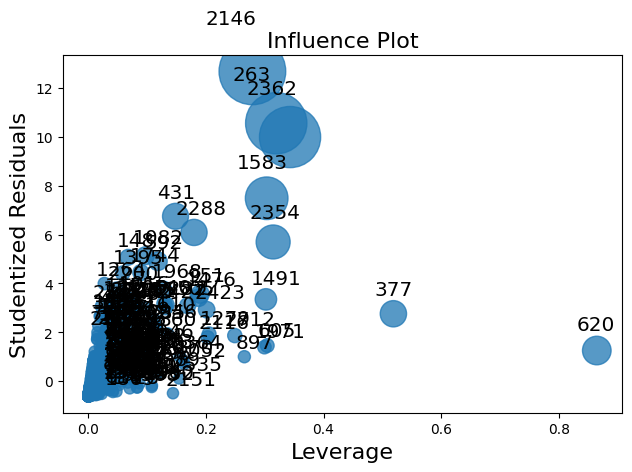

In [119]:
fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

Ta loại bỏ 4 quan sát có Cook's lớn nhất này và fit lại mô hình, quan sát các thông tin đánh giá về residual và phân phối của nó

In [120]:
dat_train.drop([1583, 2146, 263, 2362], inplace=True)

# dat_train.drop(outlier, inplace=True)

In [121]:
fitted_glm = NULL
fitted_glm = smf.glm(formula='emailmintotal_center ~ wrkstat + educ_center + polviews + advfront + harass5', \
                     data=dat_train, \
                     family=sm.families.Gamma(link=sm.families.links.Log())).fit()

fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1314
Model:                              GLM   Df Residuals:                     1290
Model Family:                     Gamma   Df Model:                           23
Link Function:                      Log   Scale:                          2.1285
Method:                            IRLS   Log-Likelihood:                 2512.6
Date:                  Mon, 14 Aug 2023   Deviance:                       2596.6
Time:                          20:40:32   Pearson chi2:                 2.75e+03
No. Iterations:                      22   Pseudo R-squ. (CS):             0.1660
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.1218      1.143     -2.732      0.006      -5.361      -0.882
wrkstat[T.Other]                     1.2998      0.365      3.563      0.000       0.585       2.015
wrkstat[T.Retired]                   0.2064      0.169      1.222      0.222      -0.125       0.537
wrkstat[T.School]                    0.2933      0.281      1.043      0.297      -0.258       0.845
wrkstat[T.Temp not working]          0.7909      0.303      2.607      0.009       0.196       1.385
wrkstat[T.Unempl, laid off]          0.7120      0.243      2.933      0.003       0.236       1.188
wrkstat[T.Working fulltime]          1.3508      0.152      8.913      0.000       1.054       1.648
wrkstat[T.Working parttime]          0.7439      0.183      4.067      0.000       0.385       1.102
polviews[T.Extremely liberal]       -0.4296      0.219     -1.961      0.050      -0.859      -0.000
polviews[T.Extrmly conservative]    -0.6307      0.242     -2.608      0.009      -1.105      -0.157
polviews[T.Liberal]                 -0.2652      0.157     -1.687      0.092      -0.573       0.043
polviews[T.Moderate]                -0.0132      0.126     -0.105      0.917      -0.260       0.234
polviews[T.Not give]                 0.3539      0.246      1.438      0.151      -0.129       0.836
polviews[T.Slghtly conservative]    -0.4102      0.151     -2.725      0.006      -0.705      -0.115
polviews[T.Slightly liberal]        -0.0836      0.163     -0.512      0.608      -0.403       0.236
advfront[T.Disagree]                 0.3035      0.152      1.994      0.046       0.005       0.602
advfront[T.Dont know]               -0.3635      0.474     -0.767      0.443      -1.292       0.565
advfront[T.Not give]                -2.5791      1.041     -2.479      0.013      -4.618      -0.540
advfront[T.Strongly agree]           0.1056      0.106      0.993      0.321      -0.103       0.314
advfront[T.Strongly disagree]        0.4565      0.521      0.877      0.381      -0.564       1.477
harass5[T.No]                        0.6795      0.395      1.722      0.085      -0.094       1.453
harass5[T.Not give]                 -1.8180      1.107     -1.642      0.101      -3.988       0.352
harass5[T.Yes]                       0.7338      0.443      1.656      0.098      -0.134       1.602
educ_center                          1.9736      0.285      6.916      0.000       1.414       2.533
====================================================================================================
"""

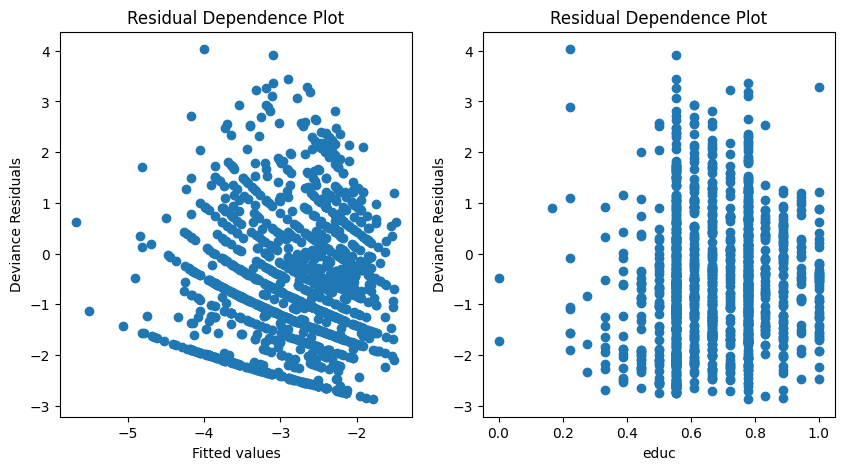

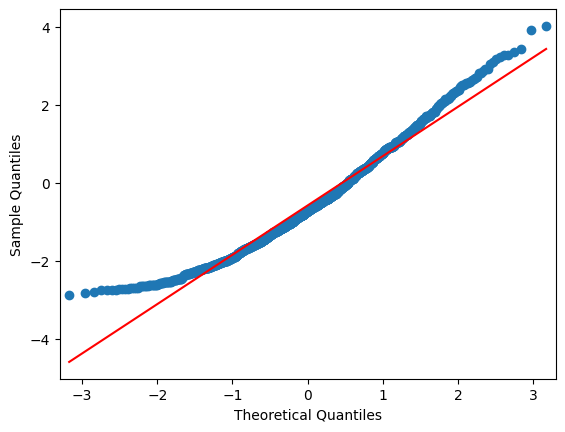

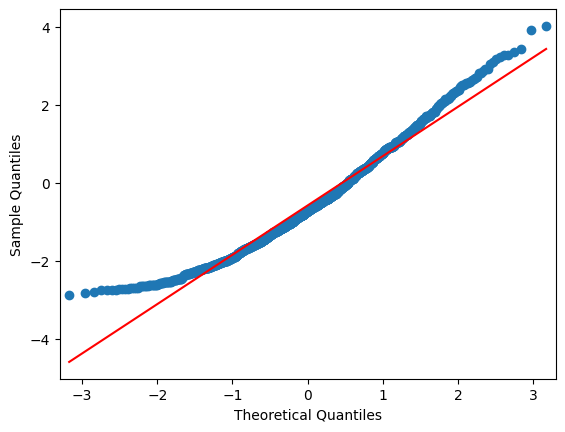

In [122]:
resid = fitted_glm.resid_deviance

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(np.log(fitted_glm.mu), resid)
# ax[0].hlines(0, 0, 1)
ax[0].set_title('Residual Dependence Plot')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_xlabel('Fitted values')

X_train = dat_train.drop(["emailmintotal_center"], axis=1)
ax[1].scatter(X_train['educ_center'], resid)
# ax[1].hlines(0, 0, 1)
ax[1].set_title('Residual Dependence Plot')
ax[1].set_ylabel('Deviance Residuals')
ax[1].set_xlabel('educ')
plt.show()

from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

Như vậy, sau khi loại bỏ 4 điểm Influence, mô hình có $R^2$ tăng hơn 20%, từ 0.1315 lên 0.1611. Các biểu đồ phần dư cũng cho thấy kết quả đẹp hơn so với mô hình trên tập dữ liệu ban đầu.

# 3. Mô hình GAM

In [123]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=10, degree=5)
alpha = 10

gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                             data=dat_train, smoother=bs, alpha=alpha, \
                             family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
print('AIC: ',fitted_gam.aic)
print('BIC: ',fitted_gam.bic)
fitted_gam.summary()

AIC:  -4977.808842906906
BIC:  -6668.013638779099


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1314
Model:                           GLMGam   Df Residuals:                  1290.12
Model Family:                     Gamma   Df Model:                        22.88
Link Function:                      Log   Scale:                          2.1283
Method:                           PIRLS   Log-Likelihood:                 2512.8
Date:                  Mon, 14 Aug 2023   Deviance:                       2596.1
Time:                          20:40:34   Pearson chi2:                 2.75e+03
No. Iterations:                      16   Pseudo R-squ. (CS):             0.1662
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.1320      1.145     -2.735      0.006      -5.377      -0.887
wrkstat[T.Other]                     1.3000      0.365      3.564      0.000       0.585       2.015
wrkstat[T.Retired]                   0.2070      0.169      1.226      0.220      -0.124       0.538
wrkstat[T.School]                    0.2932      0.281      1.042      0.297      -0.258       0.844
wrkstat[T.Temp not working]          0.7913      0.303      2.609      0.009       0.197       1.386
wrkstat[T.Unempl, laid off]          0.7123      0.243      2.934      0.003       0.237       1.188
wrkstat[T.Working fulltime]          1.3509      0.152      8.913      0.000       1.054       1.648
wrkstat[T.Working parttime]          0.7441      0.183      4.069      0.000       0.386       1.103
polviews[T.Extremely liberal]       -0.4292      0.219     -1.959      0.050      -0.859       0.000
polviews[T.Extrmly conservative]    -0.6308      0.242     -2.608      0.009      -1.105      -0.157
polviews[T.Liberal]                 -0.2650      0.157     -1.686      0.092      -0.573       0.043
polviews[T.Moderate]                -0.0134      0.126     -0.106      0.916      -0.261       0.234
polviews[T.Not give]                 0.3535      0.246      1.436      0.151      -0.129       0.836
polviews[T.Slghtly conservative]    -0.4101      0.151     -2.725      0.006      -0.705      -0.115
polviews[T.Slightly liberal]        -0.0840      0.163     -0.515      0.607      -0.404       0.236
advfront[T.Disagree]                 0.3049      0.152      2.003      0.045       0.007       0.603
advfront[T.Dont know]               -0.3642      0.474     -0.769      0.442      -1.293       0.564
advfront[T.Not give]                -2.5790      1.040     -2.479      0.013      -4.618      -0.540
advfront[T.Strongly agree]           0.1059      0.106      0.996      0.319      -0.102       0.314
advfront[T.Strongly disagree]        0.4575      0.521      0.879      0.380      -0.563       1.478
harass5[T.No]                        0.6796      0.395      1.723      0.085      -0.094       1.453
harass5[T.Not give]                 -1.8178      1.107     -1.642      0.101      -3.988       0.352
harass5[T.Yes]                       0.7347      0.443      1.658      0.097      -0.134       1.603
educ_center_s0                       0.2209      0.042      5.276      0.000       0.139       0.303
educ_center_s1                       0.4640      0.087      5.348      0.000       0.294       0.634
educ_center_s2                       0.7491      0.134      5.591      0.000       0.487       1.012
educ_center_s3                       1.0633      0.176      6.049      0.000       0.719       1.408
educ_center_s4                 

Cố định các tham số degree, df, dùng grid search để chọn alpha tối ưu.

In [124]:
# aic_gam = []
# bic_gam = []

# # al = [1, 10, 100, 1000, 5000, 10000]
# al = range(20)

# for i in range(len(al)):
#     x_spline = dat_train["educ_center"]
#     bs = BSplines(x_spline, df=5, degree=3)

#     gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
#                                  data=dat_train, smoother=bs, alpha=al[i], \
#                                  family=sm.families.Gamma(link=sm.families.links.Log()))

#     fitted_gam = gam_bs.fit()

#     aic_gam.append(fitted_gam.aic)
#     bic_gam.append(fitted_gam.bic)

# plt.plot(range(len(aic_gam)), aic_gam)
# plt.title("AIC of GAM")
# plt.show()

# plt.plot(range(len(bic_gam)), bic_gam)
# plt.title("BIC of GAM")
# plt.show()

In [125]:
# x_spline = dat_train["educ_center"]
# bs = BSplines(x_spline, df=10, degree=3)

# # gam_bs = GLMGam.from_formula(formula = 'emailmintotal ~ wrkstat + polviews + advfront + harass5', \
# gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5 + instagrm + snapchat', \
#                                 data=dat_train, smoother=bs, alpha=3, \
#                                 family=sm.families.Gamma(link=sm.families.links.Log()))

# fitted_gam = gam_bs.fit()
# fitted_gam.summary()

# #"wrkstat", "educ", "polviews", "advfront", "harass5", "wrkstat:educ", "polviews:advfront", "wrkstat:harass5", "snapchat:instagrm", "instagrm", "snapchat"

**Diagnostic**

**Grid search để tìm các tham số BSpline tối ưu**

# 4. So sánh kết quả 2 mô hình

Phần này ta sẽ dùng **Cross Validation** để cùng chia tập train/test theo các cách ngẫu nhiên khác nhau, ghi lại kết quả và so sánh trung bình các thông số đánh giá của 2 mô hình như RMSE, $R^2$, thời gian thực thi.

In [126]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
 

class StatsModelsEstimator(BaseEstimator, RegressorMixin):

    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
        self.family = sm.families.Gamma(link=sm.families.links.Log())

    def fit(self, X, y, **fit_params):
        if fit_params['model'] == 'glm':
            self.model = self.model_class.from_formula(formula=self.formula, data=X, family=self.family)
            self.results_ = self.model.fit()
        elif fit_params['model'] == 'gam':
            x_spline = X["educ_center"]
            bs = BSplines(x_spline, df=10, degree=5)
            alpha = 10
            self.model = self.model_class.from_formula(formula=self.formula, data=X, family=self.family, smoother=bs, alpha=alpha)
            self.results_ = self.model.fit()
        else:
            self.model = self.model_class.from_formula(formula=self.formula, data=X, family=self.family)
            self.results_ = self.model.fit_regularized(method='elastic_net', alpha=0.04,start_params=None, refit=False, opt_method='bfgs')
        

    def predict(self, X, **predict_params):
        return self.results_.predict(exog = X, **predict_params)

In [127]:
glm = StatsModelsEstimator(sm.GLM, formula_str)
kfold = KFold(n_splits=5)
r2 = cross_val_score(glm, dat_train, y_train_, cv=kfold, scoring='r2', fit_params={'model':'glm'})
rsme = cross_val_score(glm, dat_train, y_train_, cv=kfold, scoring='neg_root_mean_squared_error', fit_params={'model':'glm'})
msg = "r2: %f (%f)" % (r2.mean(), r2.std())
print(msg)
msg = "rsme: %f (%f)" % (rsme.mean(), rsme.std())
print(msg)

r2: 0.076345 (0.038929)
rsme: -0.103877 (0.008251)


In [128]:
elastic = StatsModelsEstimator(sm.GLM, formula_str)
kfold = KFold(n_splits=5)
r2 = cross_val_score(elastic, dat_train, y_train_, cv=kfold, scoring='r2', fit_params={'model':'g'})
rsme = cross_val_score(elastic, dat_train, y_train_, cv=kfold, scoring='neg_root_mean_squared_error', fit_params={'model':'g'})
msg = "r2: %f (%f)" % (r2.mean(), r2.std())
print(msg)
msg = "rsme: %f (%f)" % (rsme.mean(), rsme.std())
print(msg)

r2: 0.067831 (0.023797)
rsme: -0.104342 (0.007743)


In [131]:
gam = StatsModelsEstimator(GLMGam, formula_str)
kfold = KFold(n_splits=5)
r2 = cross_val_score(gam, dat_train, y_train_, cv=kfold, scoring='r2', fit_params={'model':'gam'})
rsme = cross_val_score(gam, dat_train, y_train_, cv=kfold, scoring='neg_root_mean_squared_error', fit_params={'model':'gam'})
msg = "r2: %f (%f)" % (r2.mean(), r2.std())
print(msg)
msg = "rsme: %f (%f)" % (rsme.mean(), rsme.std())
print(msg)

r2: nan (nan)
rsme: nan (nan)


# 5. Kết luận

Mô hình nào tốt hơn, vì sao

Vì sao $R^2$ thấp:
- dữ liệu rất phân tán. Nếu dùng ngưỡng xác định outlier thông thường với Cook's distance là 4/n (n là số dòng của tập dữ liệu train) thì có tới 110/1318 mẫu được xác định là outlier (chiếm 8,4%). Chúng em đã thử loại bỏ toàn bộ 111 mẫu này khỏi tập dữ liệu và train lại mô hình thì $R^2$ đạt cỡ trên 36% (khoảng gấp 3 lần $R^2$ nếu dùng cùng mô hình trên tập dữ liệu chưa loại outlier). Tuy nhiên, để đảm bảo tập dữ liệu gốc, chúng em chỉ loại 4 điểm có Cook's distance lớn nhất thì thấy $R^2$ đã tăng hơn 20%.
- tập dữ liệu tuy không nhỏ nhưng rất nhiều dòng chứa giá trị NaN.
- Liên quan tới thời gian dùng email của 1 người thì có thể có những thông tin quan trọng hơn so với những thông tin được cung cấp trong tập dữ liệu. Ví dụ cùng là làm việc fulltime nhưng với từng nghề nghiệp cụ thể, như công nhân so với nhân viên văn phòng sẽ có mức dùng email rất khác nhau...

Hướng phát triển tiếp theo